In [1]:
%load_ext autoreload
%autoreload 2

# Wake from Gaussian

In [2]:
import sys
sys.path.append('../')

In [3]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import scipy.constants
from scipy.interpolate import RegularGridInterpolator
mec2 = scipy.constants.value("electron mass energy equivalent in MeV") * 1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value("classical electron radius")

# Parameters

In [5]:
#sigma_z = 40e-6
#sigma_x = 134e-6 
#rho = 1538.
#gamma = 58708.

sigma_x = 10e-6
sigma_y = 10e-6 
sigma_z = 10e-6 

rho = 1.
gamma = 500.


beta = np.sqrt(1 - 1 / gamma ** 2)
beta2 = 1-1/gamma**2

# Density

In [6]:
xmax = sigma_x*5
xmin = -xmax
xptp = xmax-xmin

ymax = sigma_y*5
ymin = -ymax
yptp = ymax-ymin

zmax = sigma_z*5
zmin = -zmax
zptp = zmax-zmin

nx = 128
ny = 128
nz = 256


dx = xptp/(nx-1)
dy = yptp/(ny-1)
dz = zptp/(nz-1)

deltas = (dx, dy, dz)

xvec = np.linspace(xmin, xmax, nx)
yvec = np.linspace(ymin, ymax, ny)
zvec = np.linspace(zmin, zmax, nz)

X, Y, Z = np.meshgrid( xvec, yvec, zvec, indexing='ij')

In [7]:
from csr3d.dist import lambda_gauss3, lambda_gauss3_prime

In [8]:
density = lambda_gauss3(X, Y, Z)
norm = np.sum(density) * dx * dy *dz
density /= norm
density_prime = lambda_gauss3_prime(X, Y, Z) /norm

In [9]:
# Check that this is 1
np.sum(density)* dx * dy *dz

1.0

# Green function

In [10]:
from csr3d.wake import green_mesh

In [11]:
%%time
Gs = green_mesh(density.shape, deltas, rho=rho, beta=beta, component='s')

CPU times: user 3.54 s, sys: 385 ms, total: 3.92 s
Wall time: 3.94 s


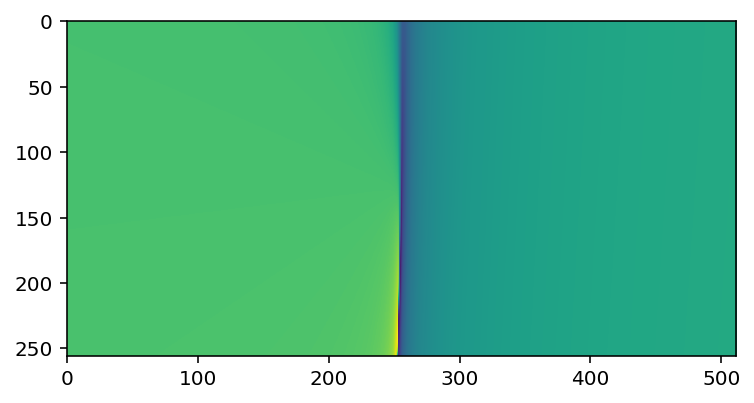

In [12]:
plt.imshow(Gs[:,16,:])

# Convolution

In [13]:
from csr3d.convolution import fftconvolve3

In [14]:
%%time
Ws = fftconvolve3(density_prime, Gs)[0]
Ws.shape

CPU times: user 2.02 s, sys: 381 ms, total: 2.4 s
Wall time: 2.41 s


(128, 128, 256)

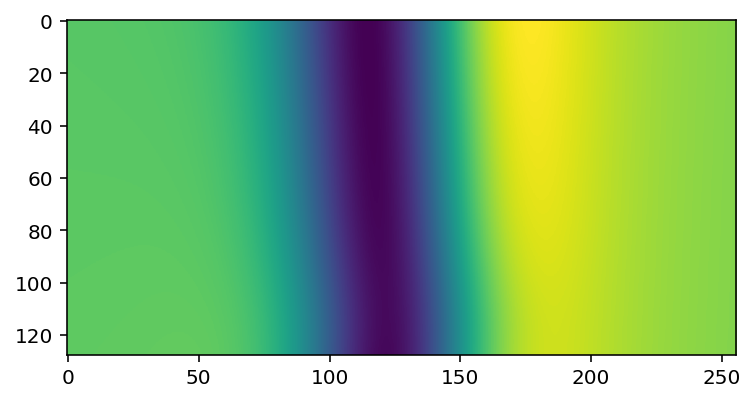

In [15]:
plt.imshow(Ws[:,16,:])

# Wake plot

Compare with Fig. 5 in

https://journals.aps.org/prab/pdf/10.1103/PhysRevAccelBeams.23.014402

In [16]:
# Conversion factor for 1/m^2
factor = (beta2 / (rho)) * (dx * dy * dz)
factor

2.431367686264785e-19

In [17]:
# Quickly get nearest indices for +/- sigma_x
ix_pos = np.abs((xvec/sigma_x) - (1)).argmin()
ix_neg = np.abs((xvec/sigma_x) - (-1)).argmin()
(xvec/sigma_x)[ix_pos], (xvec/sigma_x)[ix_neg]

(0.984251968503937, -0.984251968503937)

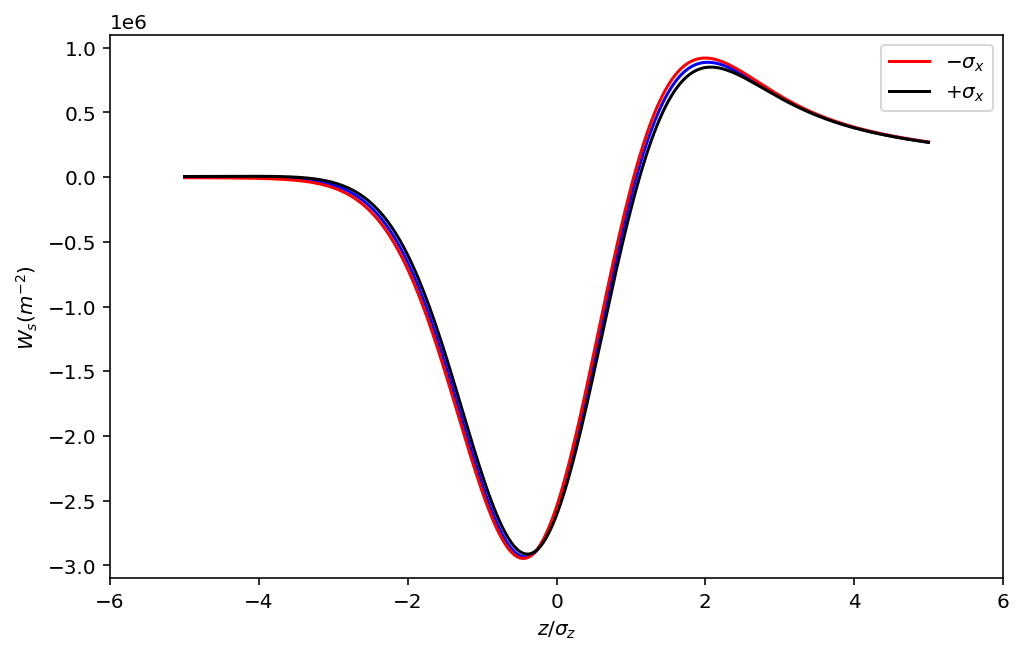

In [18]:
fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlim(-6,6)
ax.set_ylim(-3.1e6,1.1e6)
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$W_s (m^{-2})$')
#for i in range(nx):
#    plt.plot(zvec/sigma_z, Ws[i, ny//2, :]*factor)
ax.plot(zvec/sigma_z, Ws[nx//2, ny//2, :]*factor, color='blue')    
ax.plot(zvec/sigma_z, Ws[ix_neg, ny//2, :]*factor, label=r'$-\sigma_x$', color='red')  
ax.plot(zvec/sigma_z, Ws[ix_pos, ny//2, :]*factor, label=r'$+\sigma_x$', color='black')  
ax.legend()

# psi_x

Compare with Fig. 6 in

https://journals.aps.org/prab/pdf/10.1103/PhysRevAccelBeams.23.014402

In [19]:
%%time
Gx = green_mesh(density.shape, deltas, rho=rho, beta=beta, component='x')
Gx.min()

CPU times: user 13.6 s, sys: 426 ms, total: 14 s
Wall time: 14.1 s


-6.413972096735636

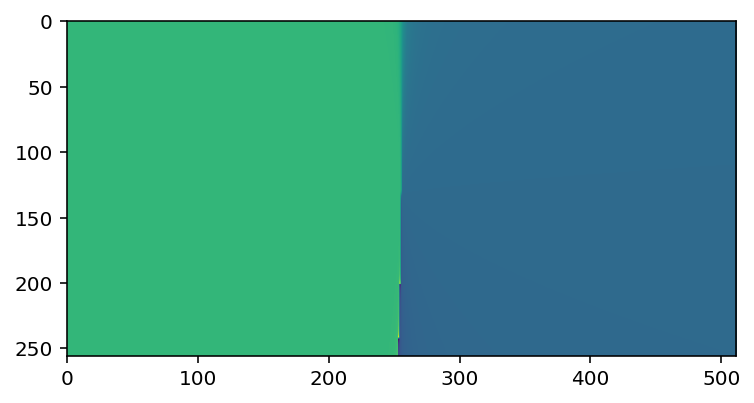

In [20]:
plt.imshow(Gx[:,ny-1,:])

In [21]:
%%time
Wx = fftconvolve3(density_prime, Gx)[0]
Wx.shape

CPU times: user 2.08 s, sys: 401 ms, total: 2.48 s
Wall time: 2.49 s


(128, 128, 256)

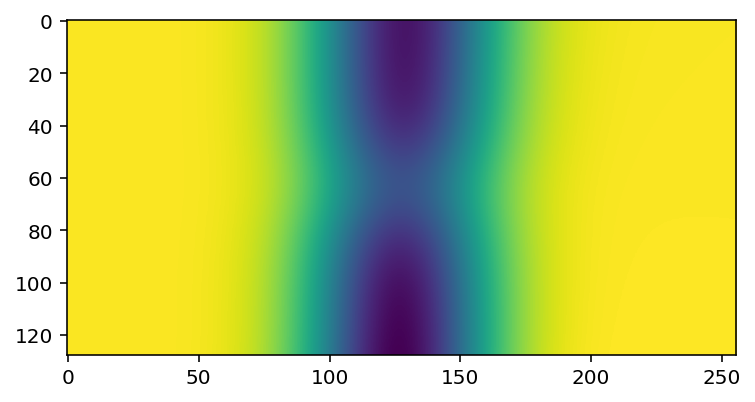

In [22]:
plt.imshow(Wx[:,ny//2,:])

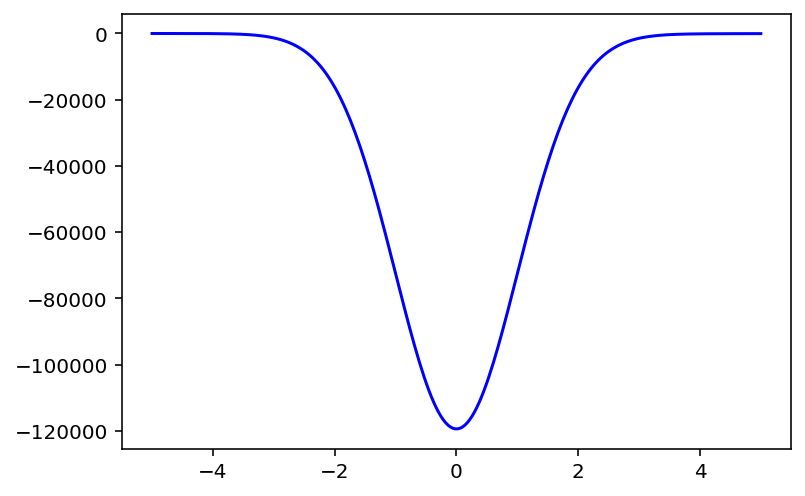

In [23]:
plt.plot(zvec/sigma_z, Wx[nx//2, ny//2, :]*factor, color='blue') 

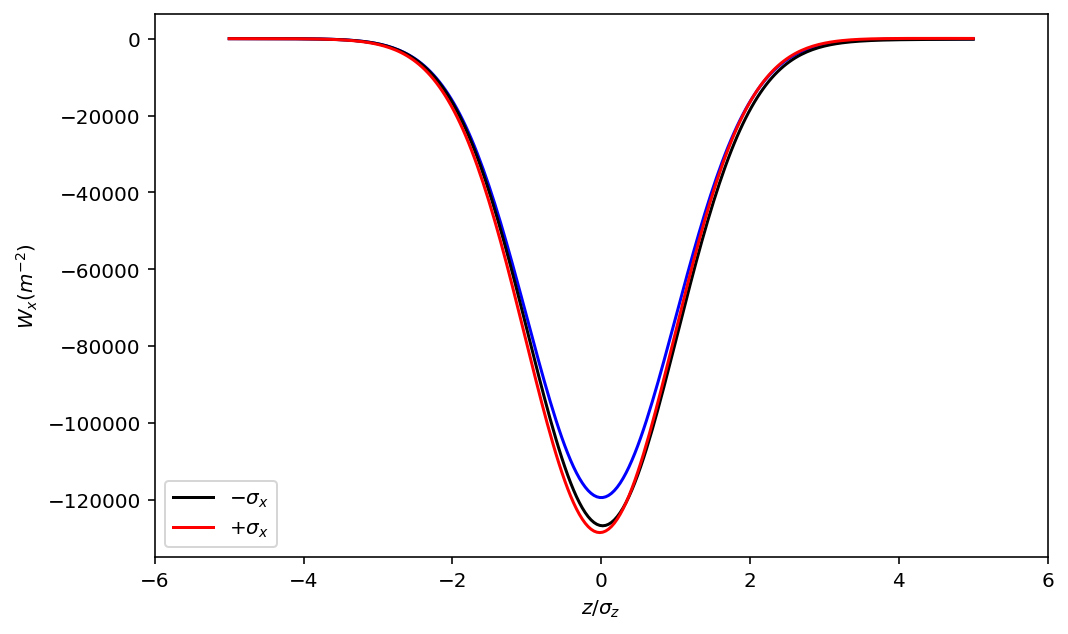

In [24]:
fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlim(-6,6)
#ax.set_ylim(-3.1e6,1.1e6)
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$W_x (m^{-2})$')
#for i in range(nx):
#    plt.plot(zvec/sigma_z, Ws[i, ny//2, :]*factor)
ax.plot(zvec/sigma_z, Wx[nx//2, ny//2, :]*factor, color='blue')    
ax.plot(zvec/sigma_z, Wx[ix_neg, ny//2, :]*factor, label=r'$-\sigma_x$', color='black')  
ax.plot(zvec/sigma_z, Wx[ix_pos, ny//2, :]*factor, label=r'$+\sigma_x$', color='red')  
ax.legend()

# psi_y

Compare with Fig. 8 in

https://journals.aps.org/prab/pdf/10.1103/PhysRevAccelBeams.23.014402



In [25]:
%%time
Gy = green_mesh(density.shape, deltas, rho=rho, beta=beta, component='y')

CPU times: user 13.5 s, sys: 445 ms, total: 13.9 s
Wall time: 14 s


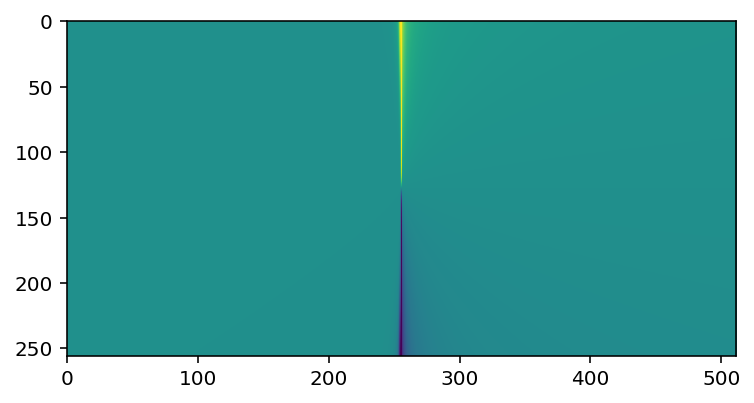

In [26]:
plt.imshow(Gy[nx-1,:,:])

In [27]:
%%time
Wy = fftconvolve3(density_prime, Gy)[0]
Wy.shape

CPU times: user 2.3 s, sys: 503 ms, total: 2.8 s
Wall time: 2.92 s


(128, 128, 256)

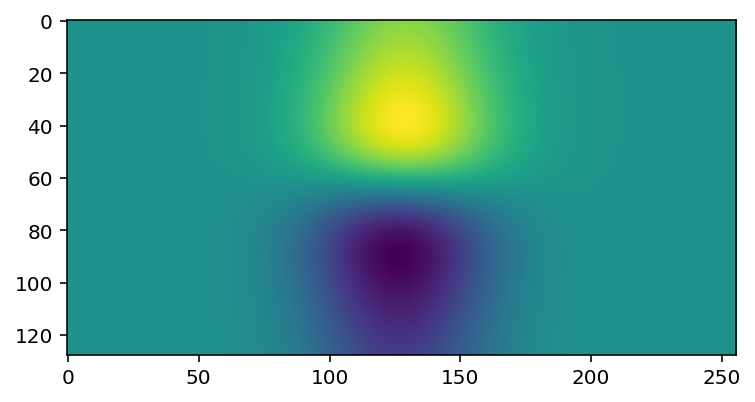

In [28]:
plt.imshow(Wy[:,ny//2,:])

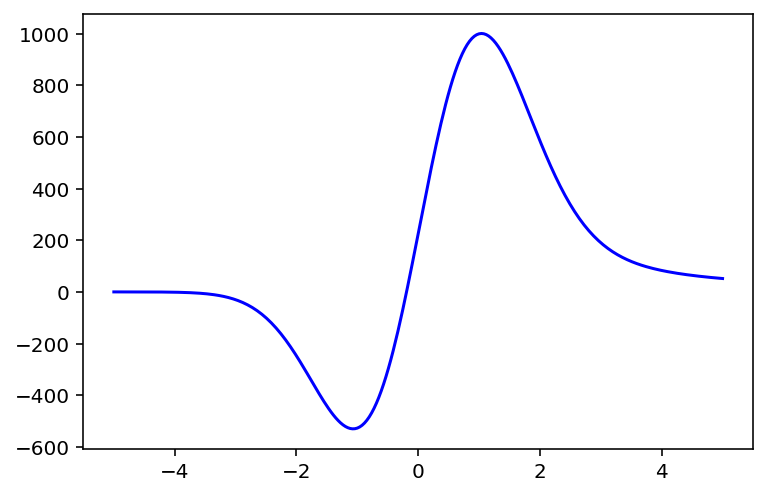

In [29]:

iy_pos = np.abs((yvec/sigma_y) - (1)).argmin()

plt.plot(zvec/sigma_z, Wy[nx//2-1, iy_pos, :]*factor, color='blue') 

In [30]:
(yvec/sigma_y)[iy_pos]

0.984251968503937

In [31]:
(xvec/sigma_x)[nx//2-1]

-0.03937007874015797

Text(0, 0.5, '$W_y (m^{-2})$')

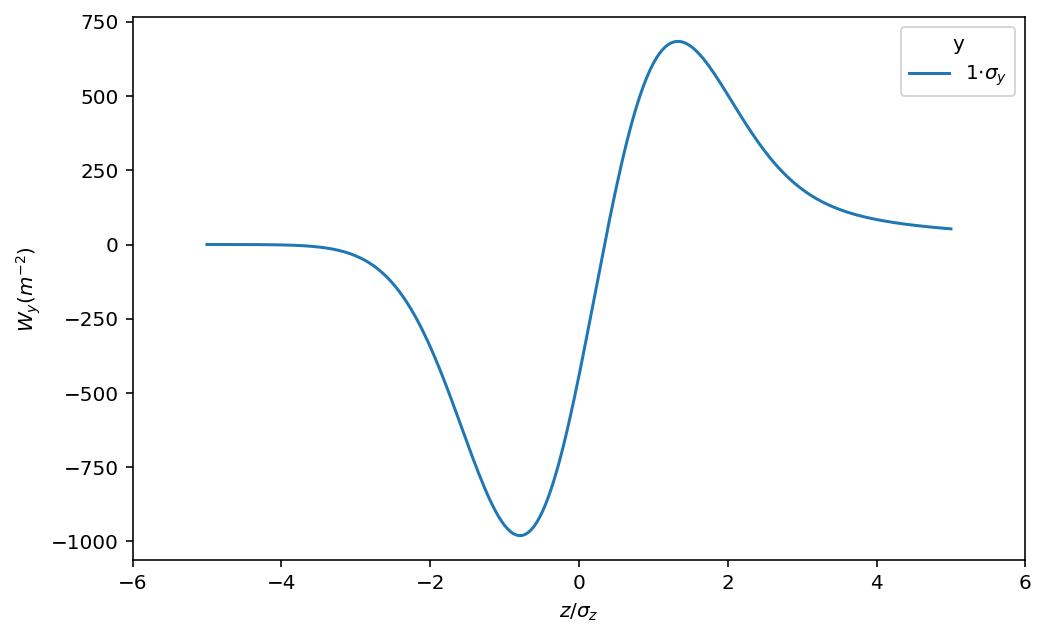

In [40]:
# Make interpolator
Wy_interp = RegularGridInterpolator([xvec, yvec, zvec], Wy)


fig, ax = plt.subplots(figsize=(8,5))
for yi in [1]: #np.arange(-1,1.5,0.5):
    pts = np.array([[0, yi*sigma_y, z] for z in zvec])
    vals = Wy_interp(pts)
    ax.plot(zvec/sigma_z, vals*factor, label=f'{yi}'+r'$\cdot\sigma_y$')
ax.legend(title='y')

ax.set_xlim(-6,6)
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$W_y (m^{-2})$')

In [33]:
LABEL='Wy'

X, Z= np.meshgrid(xvec, zvec, indexing="ij")
W = Wy[:,ny//2,:]

cdata = density.sum(axis=1)

from mpl_toolkits.mplot3d import Axes3D
cmap = matplotlib.cm.get_cmap('inferno')

W.shape, Z.shape, X.shape, cdata.shape

((128, 256), (128, 256), (128, 256), (128, 256))

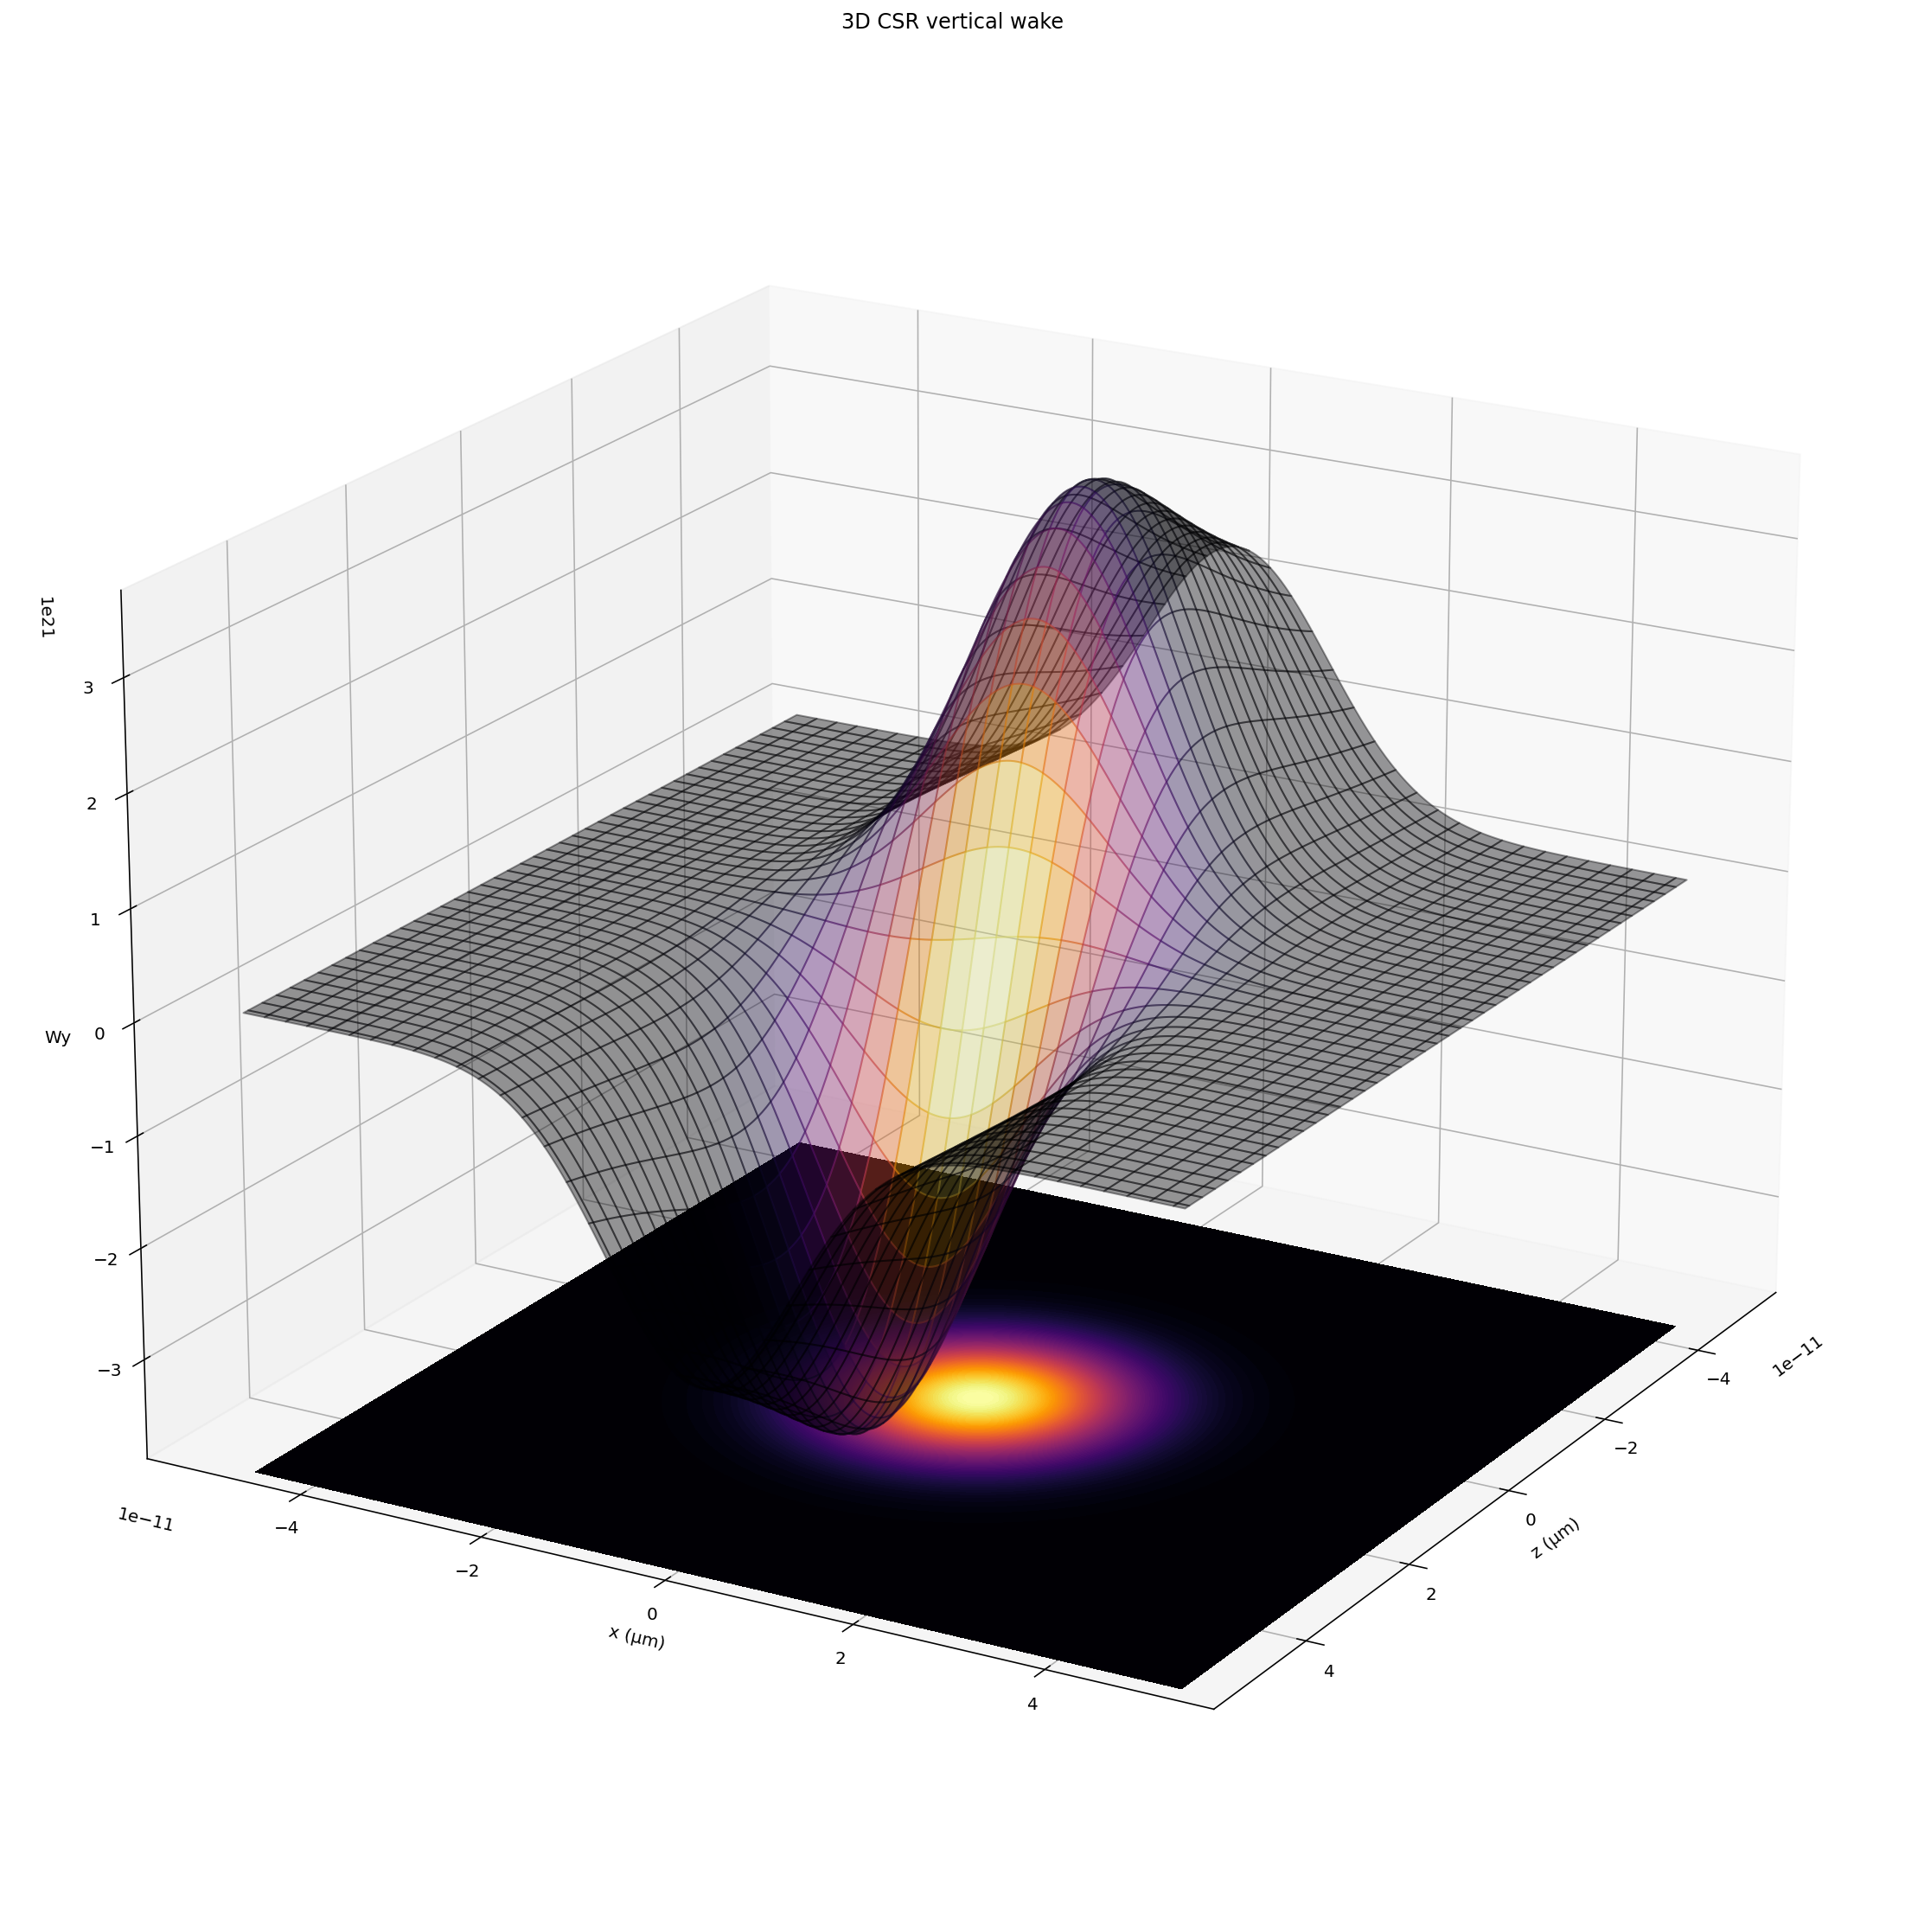

In [39]:
colors = cmap(cdata/cdata.max())
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X/1e6, Z/1e6, W, alpha=0.4, facecolors=colors)

#ax.contourf(Z, X, W, zdir='y', offset=Z.min(), cmap=matplotlib.cm.coolwarm)
ax.contourf(Z/1e6, X/1e6, cdata, 100, zdir='z', offset=W.min()*1.1, extent=[zmin, zmax, xmin, xmax], cmap=cmap)
ax.set_title('3D CSR vertical wake')
ax.set_xlabel('z (µm)')
ax.set_ylabel('x (µm)')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel(LABEL, rotation=0)
ax.view_init(20, 30)
#plt.savefig(f'{KEY}_3d.png', dpi=150)